In [36]:
import time
import torchvision
from torchvision import  transforms
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pytorch_utils

0.5420868396759033


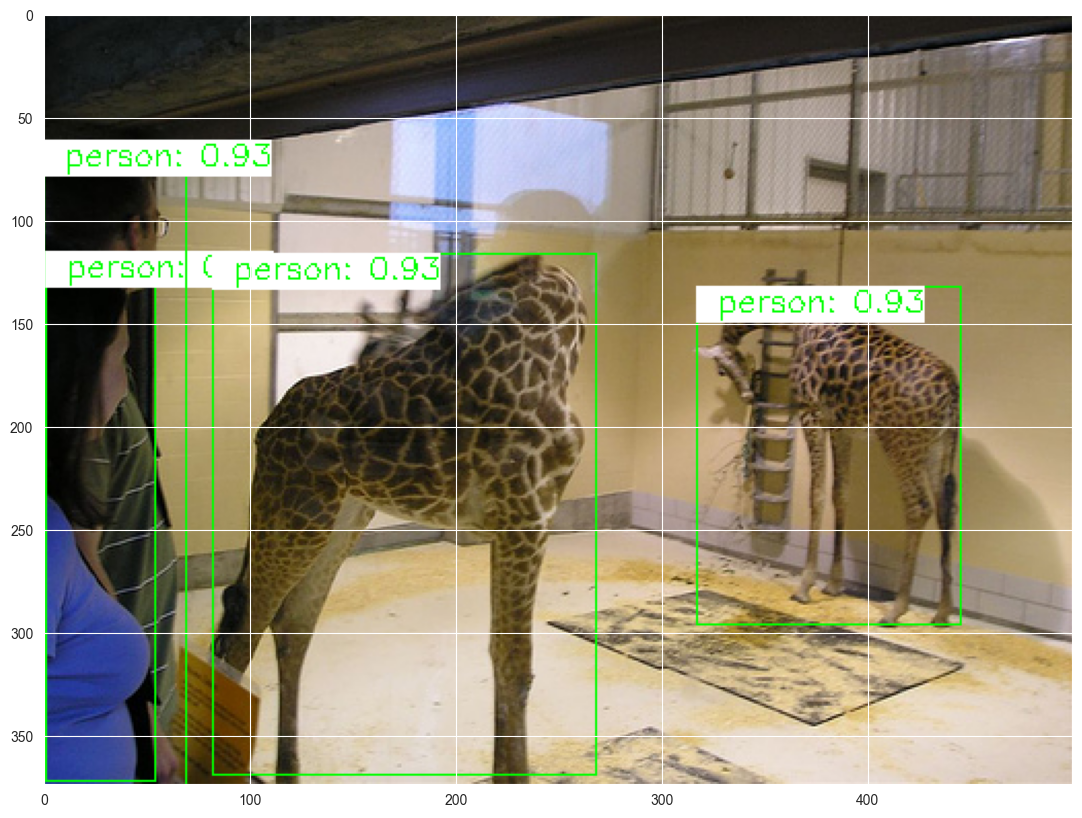

In [73]:
def coord_calculator(x, y, w, h, ih, iw):
        x1 = (x - (w / 2)) * iw
        x2 = (x + (w / 2)) * iw
        y1 = (y - (h / 2)) * ih
        y2 = (y + (h / 2)) * ih
        return round(x1), round(y1), round(x2), round(y2)

fs = [# '/Users/ashleycui/data/coco2014/val2014/COCO_val2014_000000000042.jpg',
        '/Users/ashleycui/data/coco2014/val2014/COCO_val2014_000000000136.jpg',
      # '/Users/ashleycui/data/coco2014/val2014/COCO_val2014_000000001083.jpg',
      # '/Users/ashleycui/data/coco2014/val2014/COCO_val2014_000000001374.jpg',
      # '/Users/ashleycui/data/coco2014/val2014/COCO_val2014_000000001561.jpg'
]

half = 0.5
duration = 0
for i in fs:
        # model
        start = time.time()
        model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
        model_.eval()
        for name, param in model_.named_parameters():
                # freezing the part of the model as no changes happen to its parameters
                param.requires_grad = False
        def model(x):
                with torch.no_grad():
                        yhat = model_(x)
                return yhat
        end = time.time()
        duration += (end - start)
        print(duration)
        
        # getting image
        img_path = i
        image = Image.open(img_path)
        image.resize([int(half * s) for s in image.size])
        dims = image.size
        transform = transforms.Compose([transforms.ToTensor()])
        img = transform(image)
        
        # getting pred
        pred = model([img])
        pred_thresh = pytorch_utils.get_predictions(pred, threshold=0.5)
        # pytorch_utils.draw_box(pred_thresh, img, rect_th=1, text_size= 0.5, text_th=1)
        img = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

        # reading txt file 
        with open('/Users/ashleycui/data/txt/COCO_val2014_000000000136.txt','r') as f:
                for line in f.readlines():
                        segs = line.split()
                        clz = int(segs[0])
                        cx, cy = float(segs[1]), float(segs[2])
                        w, h = float(segs[3]), float(segs[4])

                        x1, y1, x2, y2 = coord_calculator(cx, cy, w, h, dims[1], dims[0])
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

                        # text_size= 0.5
                        # text_th=1
                        # cv2.rectangle(img, (x1, y1), (x1+110, y1+17), (255, 255, 255), -1)
                        # cv2.putText(img, label, (x1+10, y1+12),  cv2.FONT_HERSHEY_SIMPLEX,
                        #             text_size, (0,255,0), thickness=text_th)
                        # cv2.putText(img, label+": "+str(round(probability, 2)),
                        #             (x1+10, y1+12),  cv2.FONT_HERSHEY_SIMPLEX, text_size,
                        #             (0, 255, 0),thickness=text_th)
                        
                        for predicted_class in pred_thresh:
                                label = predicted_class[0]
                                probability = predicted_class[1]
                                box = predicted_class[2]
                                t = round(box[0][0].tolist())
                                l = round(box[0][1].tolist())
                                r = round(box[1][0].tolist())
                                b = round(box[1][1].tolist())

                                text_size= 0.5
                                text_th=1
                                cv2.rectangle(img, (x1, y1), (x1+110, y1+17), (255, 255, 255), -1)
                                # cv2.putText(img, label, (x1+10, y1+12),  cv2.FONT_HERSHEY_SIMPLEX,
                                #             text_size, (0,255,0), thickness=text_th)
                                cv2.putText(img, label+": "+str(round(probability, 2)),
                                            (x1+10, y1+12),  cv2.FONT_HERSHEY_SIMPLEX, text_size,
                                            (0, 255, 0),thickness=text_th)

        img = np.array(img)
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # if download_image:
        #     # plt.savefig(f'{img_name}.png')
        # else:
        #     pass
        plt.show()